## 1. Data Load / Cleaning / Library Import

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [62]:
# Load the data 
df = pd.read_csv("pg_BA_ga4_events.csv")


In [63]:
# Search for missing values
df.describe(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50631 entries, 0 to 50630
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           50631 non-null  object 
 1   event_timestamp   50631 non-null  object 
 2   event_name        50631 non-null  object 
 3   product_id        50631 non-null  object 
 4   product_category  50631 non-null  object 
 5   session_id        50631 non-null  object 
 6   device_type       50631 non-null  object 
 7   purchase_value    1698 non-null   float64
dtypes: float64(1), object(7)
memory usage: 3.1+ MB


(       purchase_value
 count     1698.000000
 mean       156.110336
 std         73.745547
 min         40.040000
 25%         95.117500
 50%        138.425000
 75%        218.485000
 max        299.960000,
 None)

In [64]:
# Search for missing values
missing_values = df.isna().sum().to_frame(name="Missing_Values")
missing_values["Total_Values"] = len(df)
missing_values["Missing_%"] = (missing_values["Missing_Values"] / missing_values["Total_Values"]) * 100

missing_values

,Missing_Values,Total_Values,Missing_%
user_id,0,50631,0.000000
event_timestamp,0,50631,0.000000
event_name,0,50631,0.000000
product_id,0,50631,0.000000
product_category,0,50631,0.000000
session_id,0,50631,0.000000
device_type,0,50631,0.000000
purchase_value,48933,50631,96.646323


In [65]:
#assert dtypes
df["event_timestamp"] = pd.to_datetime(df["event_timestamp"])


## 2. Feature Engineering

### 2.1 Initial Feature Selection

In [66]:
user_features = df.groupby("user_id").agg(
    total_events=("event_name", "count"),
    unique_sessions=("session_id", "nunique"),
    purchases=("event_name", lambda x: (x == "purchase").sum()),
    total_spent=("purchase_value", "sum"),
    active_days=("event_timestamp", lambda x: x.dt.date.nunique())
).fillna(0)

user_features["device_type"] = df.groupby("user_id")["device_type"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown"
)
user_features["events_per_session"] = user_features["total_events"] / user_features["unique_sessions"]
user_features["spending_per_session"] = user_features["total_spent"] / user_features["unique_sessions"]
user_features["purchase_rate_per_session"] = user_features["purchases"] / user_features["unique_sessions"]

add_to_carts = df[df["event_name"] == "add_to_cart"].groupby("user_id").size()
user_features["add_to_carts"] = add_to_carts.fillna(0)
user_features["checkout_completion_rate"] = user_features["purchases"] / user_features["add_to_carts"]

purchases = df[df["event_name"] == "purchase"]
unique_products = purchases.groupby("user_id")["product_id"].nunique()
user_features["unique_products_total"] = unique_products.fillna(0)

category_spending = purchases.groupby(["user_id", "product_category"])["purchase_value"].sum()
total_spending = category_spending.groupby("user_id").sum()
category_ratio = category_spending / total_spending
dominant_share = category_ratio.groupby("user_id").max()
user_features["dominant_category_share"] = dominant_share.fillna(0)


### 2.2 Feature Re-Evaluation

In [67]:
## Avoid redundancys bc K-Means treat each feature equally important --> to not overemphasize a particular user behaviour

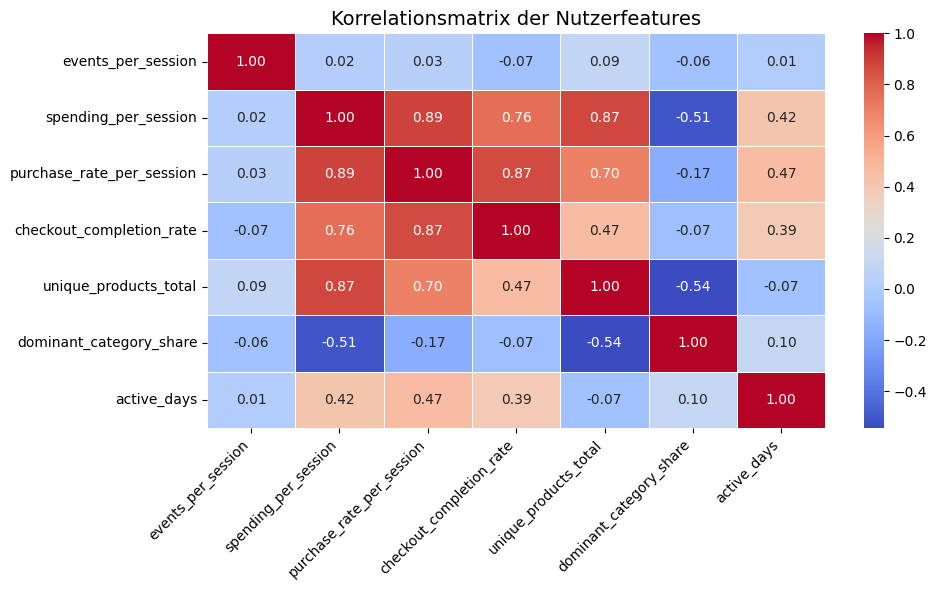

In [68]:


features_all = user_features[[
    "events_per_session", "spending_per_session", "purchase_rate_per_session",
    "checkout_completion_rate", "unique_products_total",
    "dominant_category_share", "active_days"
]]

# Korrelation & Heatmap
corr_matrix = features_all.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korrelationsmatrix der Nutzerfeatures", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [69]:
# dropping spending per session

In [70]:
features = user_features[[
    "events_per_session",
    "purchase_rate_per_session",
    "checkout_completion_rate",
    "unique_products_total",
    "dominant_category_share",
    "active_days"
]].fillna(0)


## 3.1 Clustering

In [71]:


scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_features["segment"] = kmeans.fit_predict(X_scaled)


## 3.2 Clustering Eval

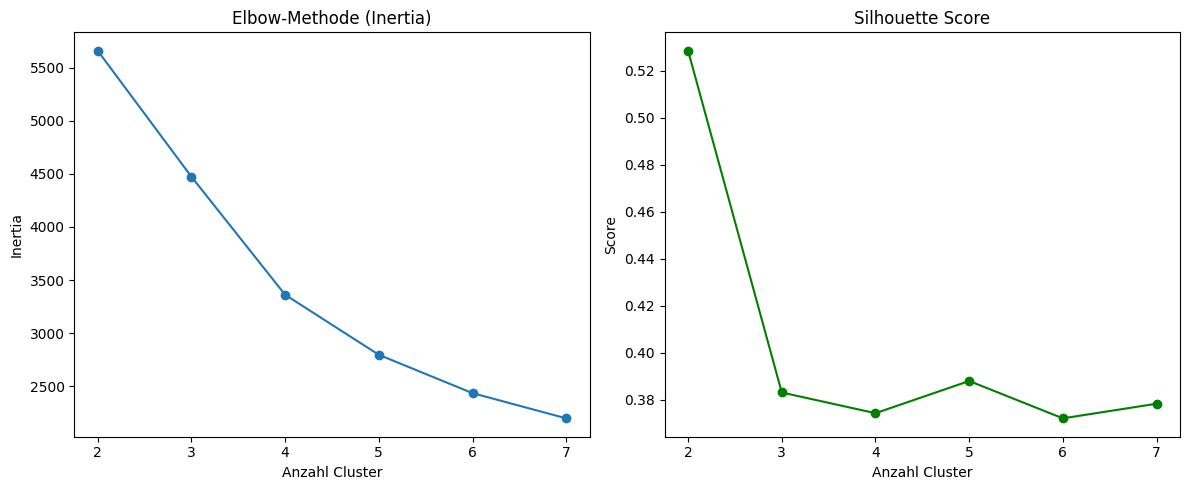

   n_clusters   inertia  silhouette_score
0           2  5659.899             0.529
1           3  4473.545             0.383
2           4  3361.990             0.374
3           5  2796.476             0.388
4           6  2435.433             0.372
5           7  2198.052             0.378


In [72]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. Skalierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  # <--- kommt aus Step 3

# 2. Test verschiedener Clustergrößen
inertias = []
silhouette_scores = []
range_n_clusters = range(2, 8)  # du kannst bis 10 hochgehen

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# 3. Visualisierung (optional, für lokale Umgebung)
plt.figure(figsize=(12, 5))

# Elbow-Plot
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertias, marker='o')
plt.title("Elbow-Methode (Inertia)")
plt.xlabel("Anzahl Cluster")
plt.ylabel("Inertia")

# Silhouette-Plot
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Anzahl Cluster")
plt.ylabel("Score")

plt.tight_layout()
plt.show()

# 4. Ausgabe als Tabelle (optional)
scores = pd.DataFrame({
    "n_clusters": range_n_clusters,
    "inertia": inertias,
    "silhouette_score": silhouette_scores
})
print(scores.round(3))


## 4. Clusteranalyse

In [73]:
cluster_summary = user_features.groupby("segment")[features.columns].mean().round(2)
cluster_summary["user_count"] = user_features["segment"].value_counts().sort_index()
cluster_summary


,events_per_session,purchase_rate_per_session,checkout_completion_rate,unique_products_total,dominant_category_share,active_days,user_count
segment,,,,,,,
0,4.51,0.17,0.20,1.84,0.92,4.58,449
1,4.55,0.39,0.52,4.04,0.83,4.18,211
2,3.62,0.00,0.00,NaN,NaN,2.48,778
3,5.69,0.00,0.00,NaN,NaN,2.00,562


In [74]:
cluster_summary["user_count"].sum()

np.int64(2000)

### 5. Final preparation for dashboard

In [77]:
# Re-run the entire process using the re-uploaded CSV file

# Load and preprocess data
df = pd.read_csv("pg_BA_ga4_events.csv")
df["event_timestamp"] = pd.to_datetime(df["event_timestamp"])

# Compute user-level features
user_features = df.groupby("user_id").agg(
    total_events=("event_name", "count"),
    unique_sessions=("session_id", "nunique"),
    purchases=("event_name", lambda x: (x == "purchase").sum()),
    total_spent=("purchase_value", "sum"),
    active_days=("event_timestamp", lambda x: x.dt.date.nunique())
).fillna(0)

user_features["events_per_session"] = user_features["total_events"] / user_features["unique_sessions"]
user_features["spending_per_session"] = user_features["total_spent"] / user_features["unique_sessions"]
user_features["purchase_rate_per_session"] = user_features["purchases"] / user_features["unique_sessions"]

# Add to carts and checkout rate
add_to_carts = df[df["event_name"] == "add_to_cart"].groupby("user_id").size()
user_features["add_to_carts"] = add_to_carts
user_features["checkout_completion_rate"] = user_features["purchases"] / user_features["add_to_carts"]
user_features["checkout_completion_rate"] = user_features["checkout_completion_rate"].replace([np.inf, -np.inf], 0).fillna(0)

# Unique products from purchases
purchases = df[df["event_name"] == "purchase"]
unique_products = purchases.groupby("user_id")["product_id"].nunique()
user_features["unique_products_total"] = unique_products.fillna(0)

# Dominant category share (based on purchases)
category_spending = purchases.groupby(["user_id", "product_category"])["purchase_value"].sum()
total_spending = category_spending.groupby("user_id").sum()
category_ratio = category_spending / total_spending
dominant_share = category_ratio.groupby("user_id").max()
user_features["dominant_category_share"] = dominant_share.fillna(0)

# Dominant category per event (not just purchase)
dominant_category = df.groupby("user_id")["product_category"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown"
)
user_features["dominant_category"] = dominant_category

# Dominant device per user
dominant_device = df.groupby("user_id")["device_type"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown"
)
user_features["dominant_device"] = dominant_device

# Feature selection and scaling
features = user_features[[
    "events_per_session",
    "purchase_rate_per_session",
    "checkout_completion_rate",
    "unique_products_total",
    "dominant_category_share",
    "active_days"
]].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_features["segment"] = kmeans.fit_predict(X_scaled)

# Export
user_features = user_features.reset_index()
user_features.to_csv("clustered_users.csv", index=False)

user_features.head()


,user_id,total_events,unique_sessions,purchases,total_spent,active_days,events_per_session,spending_per_session,purchase_rate_per_session,add_to_carts,checkout_completion_rate,unique_products_total,dominant_category_share,dominant_category,dominant_device,segment
0,U00001,71,16,4,825.66,5,4.437500,51.603750,0.250000,10.0,0.400000,4.0,0.753022,Electronics,mobile,1
1,U00002,72,17,3,515.43,7,4.235294,30.319412,0.176471,13.0,0.230769,3.0,0.669344,Home,tablet,0
2,U00003,76,16,3,747.47,5,4.750000,46.716875,0.187500,14.0,0.214286,3.0,1.000000,Home,tablet,0
3,U00004,74,17,2,311.07,2,4.352941,18.298235,0.117647,10.0,0.200000,2.0,1.000000,Electronics,mobile,0
4,U00005,74,17,1,200.55,3,4.352941,11.797059,0.058824,15.0,0.066667,1.0,1.000000,Home,mobile,0
